In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose


# Analisis Exploratorio

In [63]:
sns.set(style="whitegrid")

# -------------------------------
# Función para detectar encabezado correcto
# -------------------------------
def detectar_header(df):
    for i in range(10):
        row = df.iloc[i].astype(str).str.lower()
        if any(word in row.to_string() for word in ['regular', 'super', 'súper', 'diesel', 'gas']):
            return i
    return 0

def cargar_con_encabezado(path):
    preview = pd.read_excel(path, header=None, nrows=15)
    header_row = detectar_header(preview)
    df = pd.read_excel(path, header=header_row)
    df.columns = df.columns.str.lower().str.strip()
    return df

# -------------------------------
# Cargar archivos
# -------------------------------
files = {
    "consumo_2024": "CONSUMO-HIDROCARBUROS-2024-12.xlsx",
    "ventas_2025": "VENTAS-HIDROCARBUROS-2025-05.xlsx",
    "import_2024": "IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx",
    "import_2025": "IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx",
    "precios": "Precios-Promedio-Nacionales-Diarios-2025-1.xlsx"
}

dfs = {k: cargar_con_encabezado(path) for k, path in files.items()}

# -------------------------------
# Función para preparar DataFrame de hidrocarburos
# -------------------------------
def preparar_df(df, fuente):
    df = df.copy()
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    df = df.dropna(subset=['fecha'])

    for col in ['diesel bajo azufre', 'diesel ultra bajo azufre', 'diesel alto azufre']:
        if col not in df.columns:
            df[col] = 0

    df_filtrado = pd.DataFrame({
        'fecha': df['fecha'],
        'gasolina_regular': df.get('gasolina regular', 0),
        'gasolina_superior': df.get('gasolina superior', 0),
        'gas_licuado': df.get('gas licuado de petróleo', 0),
        'diesel': df['diesel bajo azufre'] + df['diesel ultra bajo azufre'] + df['diesel alto azufre'],
        'fuente': fuente
    })
    return df_filtrado

# -------------------------------
# Preparar conjuntos combinados
# -------------------------------

# Consumo total
consumo_total = pd.concat([
    preparar_df(dfs["consumo_2024"], "consumo"),
    preparar_df(dfs["ventas_2025"], "ventas")
], ignore_index=True)

# Importación total
importacion_total = pd.concat([
    preparar_df(dfs["import_2024"], "importacion"),
    preparar_df(dfs["import_2025"], "importacion")
], ignore_index=True)

# Datos de precios
precios = dfs["precios"].copy()
precios.columns = precios.columns.str.lower().str.strip()
precios = precios.rename(columns={
    "superior": "gasolina_superior",
    "regular": "gasolina_regular",
    "diesel": "diesel",
    "glp cilindro 25lbs.": "gas_licuado"
})
precios['fecha'] = pd.to_datetime(precios['fecha'], errors='coerce')
precios = precios.dropna(subset=['fecha'])

# -------------------------------
# Mostrar ejemplo de los resultados
# -------------------------------
print("🔥 Datos de consumo_total:")
print(consumo_total.head())

print("\n🚢 Datos de importacion_total:")
print(importacion_total.head())

print("\n💰 Datos de precios diarios:")
print(precios[['fecha', 'gasolina_regular', 'gasolina_superior', 'diesel', 'gas_licuado']].head())


🔥 Datos de consumo_total:
       fecha  gasolina_regular  gasolina_superior    gas_licuado     diesel  \
0 2000-01-01         202645.20          308156.82  194410.476190  634667.06   
1 2000-02-01         205530.96          307766.31  174710.552381  642380.66   
2 2000-03-01         229499.56          331910.29  189234.066667  699807.25   
3 2000-04-01         210680.40          315648.08  174330.607143  586803.98   
4 2000-05-01         208164.34          319667.97  191745.147619  656948.20   

    fuente  
0  consumo  
1  consumo  
2  consumo  
3  consumo  
4  consumo  

🚢 Datos de importacion_total:
       fecha  gasolina_regular  gasolina_superior    gas_licuado     diesel  \
0 2001-01-01         177776.50          373963.96  194065.738095  566101.99   
1 2001-02-01         123115.99          243091.07  170703.380952  489525.80   
2 2001-03-01         161726.42          312084.38  161837.371429  575559.68   
3 2001-04-01         127338.74          285054.89  163048.642857  437745.4

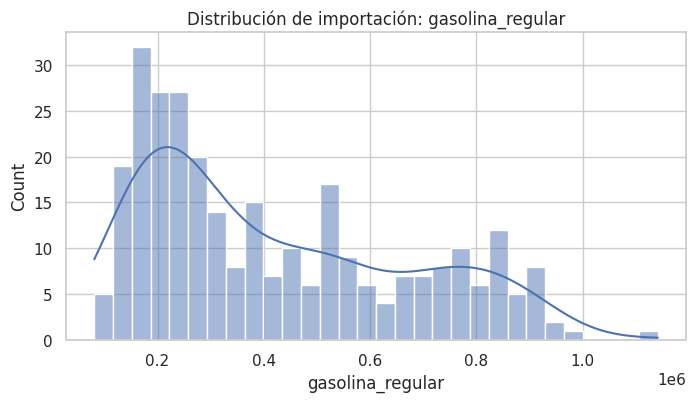

Prueba Shapiro para gasolina_regular: Estadístico=0.905, p-valor=0.000
-> La variable gasolina_regular NO sigue una distribución normal (rechazamos H0)



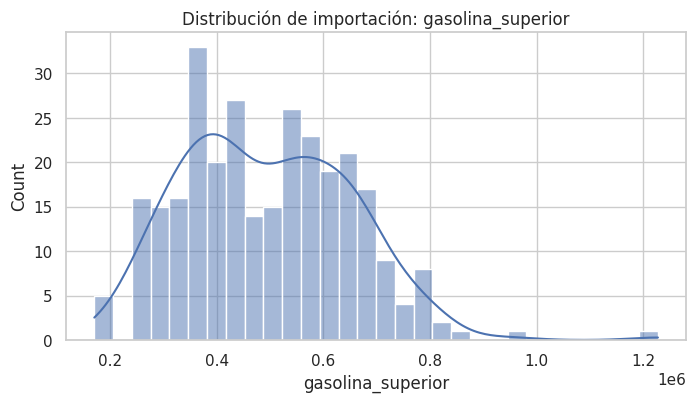

Prueba Shapiro para gasolina_superior: Estadístico=0.975, p-valor=0.000
-> La variable gasolina_superior NO sigue una distribución normal (rechazamos H0)



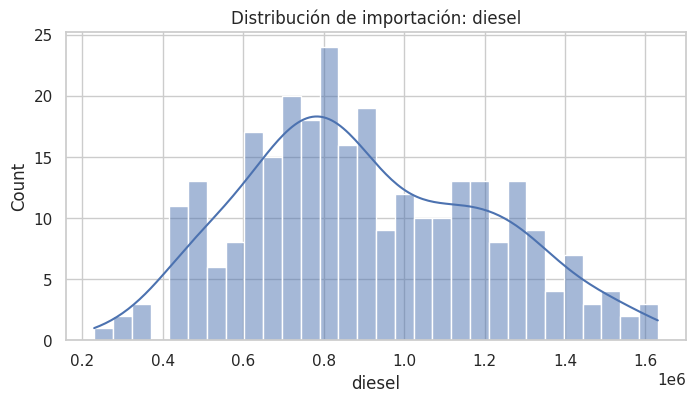

Prueba Shapiro para diesel: Estadístico=0.981, p-valor=0.001
-> La variable diesel NO sigue una distribución normal (rechazamos H0)



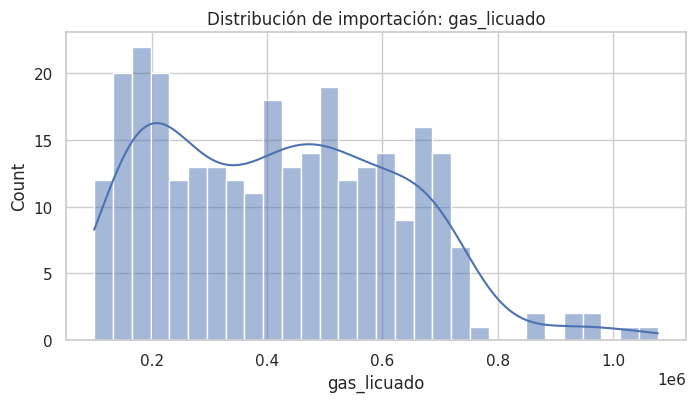

Prueba Shapiro para gas_licuado: Estadístico=0.958, p-valor=0.000
-> La variable gas_licuado NO sigue una distribución normal (rechazamos H0)



In [64]:

# Variables continuas
variables = ['gasolina_regular', 'gasolina_superior', 'diesel', 'gas_licuado']

# Histograma + KDE para ver distribución
for var in variables:
    plt.figure(figsize=(8,4))
    sns.histplot(importacion_total[var], kde=True, bins=30)
    plt.title(f'Distribución de importación: {var}')
    plt.show()

    # Prueba de normalidad Shapiro-Wilk (muestra aleatoria de 5000 para evitar error)
    muestra = importacion_total[var].dropna().sample(min(5000, len(importacion_total)), random_state=42)
    stat, p = shapiro(muestra)
    print(f'Prueba Shapiro para {var}: Estadístico={stat:.3f}, p-valor={p:.3f}')
    if p > 0.05:
        print(f"-> La variable {var} parece seguir una distribución normal (no se rechaza H0)\n")
    else:
        print(f"-> La variable {var} NO sigue una distribución normal (rechazamos H0)\n")


<Figure size 1200x600 with 0 Axes>

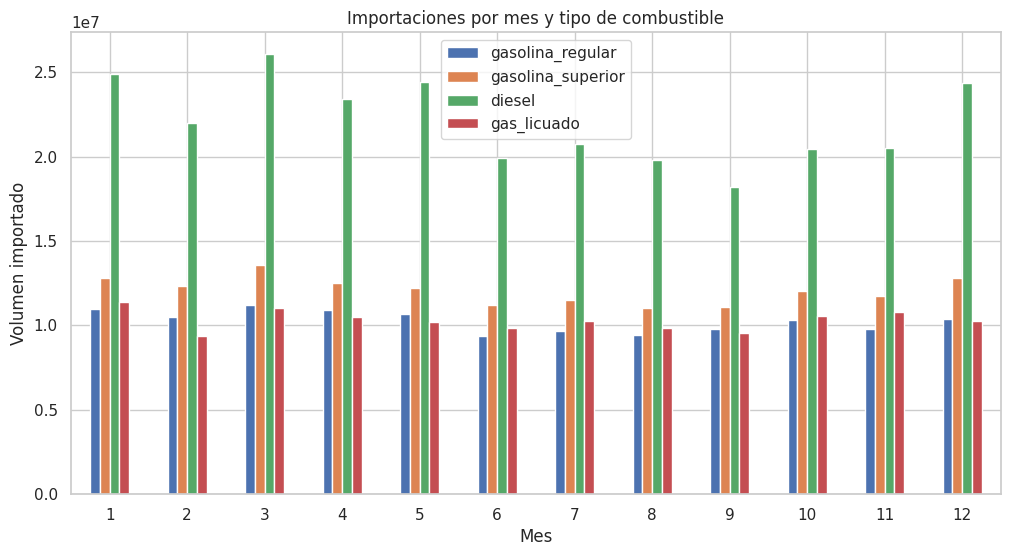

In [65]:
# Agregar por mes y combustible
importacion_total['mes'] = importacion_total['fecha'].dt.month
mes_importaciones = importacion_total.groupby('mes')[variables].sum()

plt.figure(figsize=(12,6))
mes_importaciones.plot(kind='bar')
plt.title("Importaciones por mes y tipo de combustible")
plt.xlabel("Mes")
plt.ylabel("Volumen importado")
plt.xticks(rotation=0)
plt.show()


# Análisis preliminar de 2 series

Importaciones - estadisticos: 
count    2.930000e+02
mean     9.036914e+05
std      2.993747e+05
min      2.297647e+05
25%      6.939423e+05
50%      8.508069e+05
75%      1.135350e+06
max      1.630636e+06
Name: diesel, dtype: float64

Consumo/Ventas - estadisticos: 
count    3.050000e+02
mean     8.910938e+05
std      2.376350e+05
min      5.076627e+05
25%      7.012555e+05
50%      8.149567e+05
75%      1.079270e+06
max      1.499266e+06
Name: diesel, dtype: float64


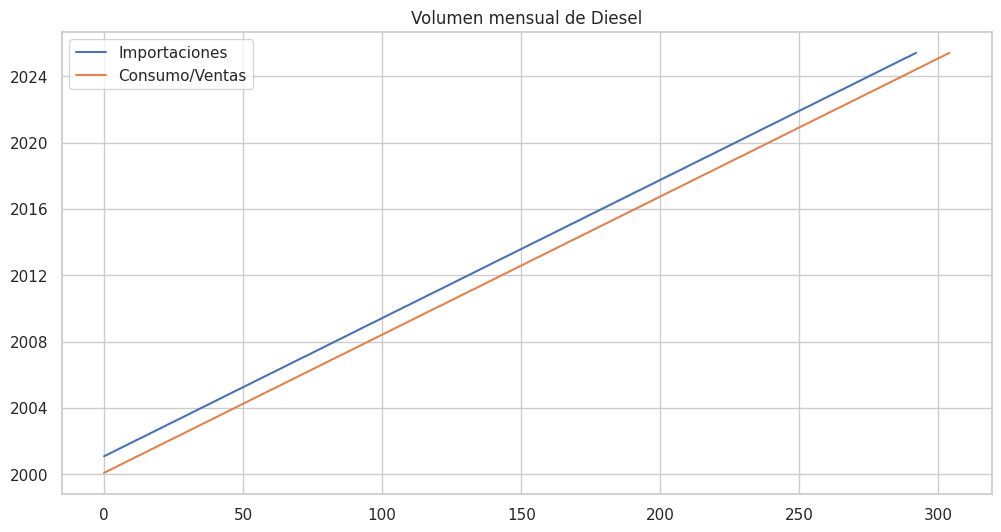

In [66]:
series_imp = importacion_total.set_index('fecha')['diesel'].resample('ME').sum()
series_con = consumo_total.set_index('fecha')['diesel'].resample('ME').sum()
print("Importaciones - estadisticos: ")
print(series_imp.describe())
print("\nConsumo/Ventas - estadisticos: ")
print(series_con.describe())

plt.figure(figsize=(12, 6))
plt.plot(series_imp.index, label='Importaciones')
plt.plot(series_con.index, label='Consumo/Ventas')
plt.title("Volumen mensual de Diesel")
plt.legend()
plt.show()


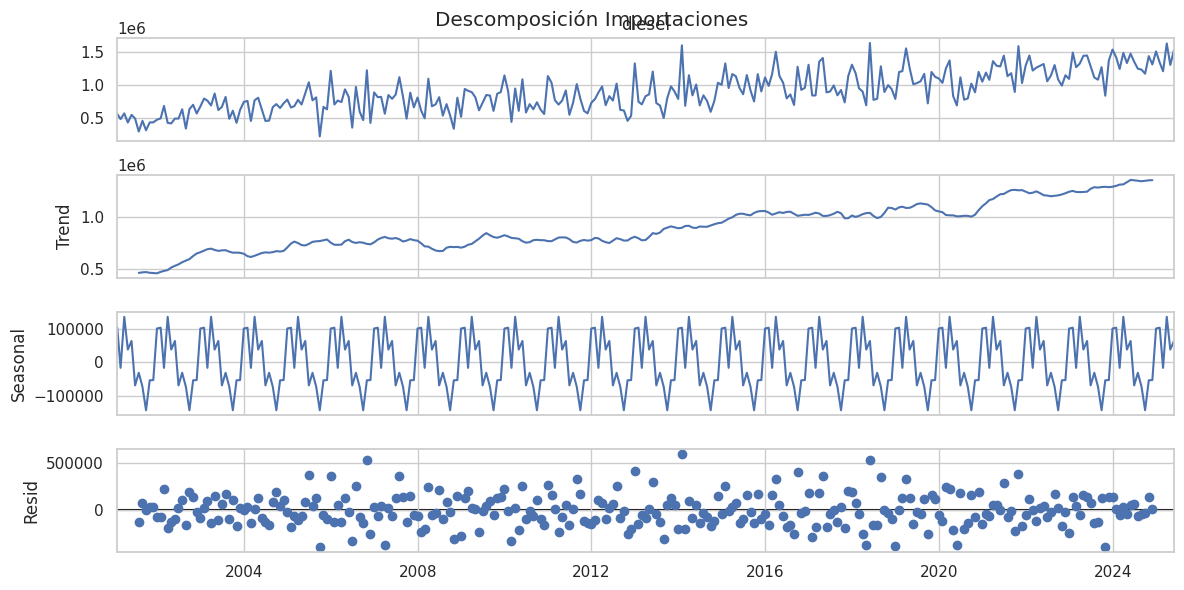

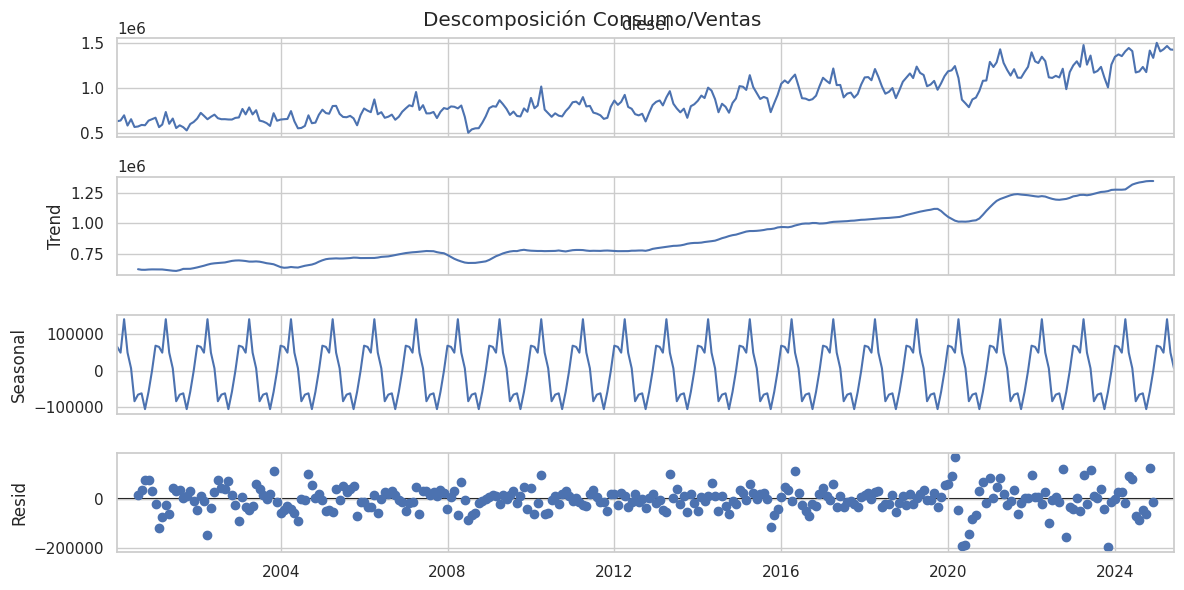

NameError: name 'autocorrelation_plot' is not defined

In [67]:
# Tendencia y estacionalidad
decomp_imp = seasonal_decompose(series_imp, model='additive', period=12)
decomp_con = seasonal_decompose(series_con, model='additive', period=12)
decomp_imp.plot(); plt.suptitle("Descomposición Importaciones"); plt.show()
decomp_con.plot(); plt.suptitle("Descomposición Consumo/Ventas"); plt.show()

# Autocorrelacion
autocorrelation_plot(series_imp.dropna()); plt.title("ACF Importaciones"); plt.show()
autocorrelation_plot(series_con.dropna()); plt.title("ACF Consumo"); plt.show()

# Correlacion entre series
corr = series_imp.corr(series_con)
print(f"Correlación Pearson entre importaciones y consumo: {corr:.3f}")
plt.figure(figsize=(6,6))
plt.scatter(series_imp, series_con)
plt.xlabel("Importaciones (M³)")
plt.ylabel("Consumo (M³)")
plt.title("Relación Importaciones vs Consumo")
plt.show()